In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

### We will try to solve the problem using Logistic regression as a linear classifier by:
- Using stochastic gradient descent in training
- Training on epochs and using batches with partial fit


#### Loading Pre-processed Dataset & Training/Eval function

In [5]:
# Load dataset from CSV
csv_file = 'Dataset/cleaned.csv' 
df = pd.read_csv(csv_file)

# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Train/Val/Test split with stratification
X_train_val, X_test, y_train_val, y_test, meter_train_val, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val, meter_train, meter_val = train_test_split(
    X_train_val, y_train_val, meter_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_val[y_val == 1]), len(y_val[y_val == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

30209 1299681
3357 144409
3730 160455
(1329890, 21) (1329890,)
(147766, 21) (147766,)
(164185, 21) (164185,)


In [7]:
def trainAndEvaluate(model, X_train, X_val, X_test, y_train, y_val, y_test, meter_val, meter_test, epochs= 5, batch_size=1024, show=False):
    train_losses, val_losses = [], []

    for epoch in tqdm(range(epochs), desc="Training"):
        X_train, y_train = shuffle(X_train, y_train, random_state=epoch)
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            model.partial_fit(X_batch, y_batch, classes=[0, 1])

        train_pred_proba = model.predict_proba(X_train)
        val_pred_proba = model.predict_proba(X_val)

        train_loss = log_loss(y_train, train_pred_proba)
        val_loss = log_loss(y_val, val_pred_proba)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        val_pred = model.predict(X_val)
        val_pred = np.where(meter_val == -1, 0, val_pred)
        
        if show:
            val_acc = accuracy_score(y_val, val_pred)
            val_f1 = f1_score(y_val, val_pred, zero_division=0)
            val_auc = roc_auc_score(y_val, val_pred_proba[:, 1])
            val_precision = precision_score(y_val, val_pred, zero_division=0)
            val_recall = recall_score(y_val, val_pred, zero_division=0)
            val_auprc = average_precision_score(y_val, val_pred_proba[:, 1])
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}, AUC-PR: {val_auprc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    # Evaluate on test set
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Set prediction to 0 where meter_reading is missing
    test_pred = np.where(meter_test == -1, 0, test_pred)

    test_acc = accuracy_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_auprc = average_precision_score(y_test, test_pred_proba)
    
    if show:
        print(f"Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}, AUC Score: {test_auc:.4f}, AUC-PR: {test_auprc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix on Test Set")
        plt.show()

        # Calculate zeroR baseline metrics
        zeroR = np.bincount(y_test).argmax()
        y_pred_zeroR = np.full_like(y_test, zeroR)
        zeroR_acc = accuracy_score(y_test, y_pred_zeroR)
        zeroR_f1 = f1_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_precision = precision_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_recall = recall_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_auc = roc_auc_score(y_test, y_pred_zeroR)
        zeroR_auprc = average_precision_score(y_test, y_pred_zeroR)
        print(f"ZeroR Baseline Metrics:", f"  Accuracy: {zeroR_acc:.4f}", f"  F1 Score: {zeroR_f1:.4f}", f"  Precision: {zeroR_precision:.4f}", f"  Recall: {zeroR_recall:.4f}", f"  AUC: {zeroR_auc:.4f}", f"  AUC-PR: {zeroR_auprc:.4f}", "\n")
    return [test_acc, test_f1, test_auc, test_precision, test_recall, test_auprc]

Training:  20%|██        | 1/5 [00:01<00:06,  1.65s/it]

Epoch 1/5 - Train Loss: 0.1083, Val Loss: 0.1085, Val Acc: 0.9773, F1: 0.0000, AUC: 0.6003, AUC-PR: 0.0359, Precision: 0.0000, Recall: 0.0000


Training:  40%|████      | 2/5 [00:03<00:05,  1.74s/it]

Epoch 2/5 - Train Loss: 0.1074, Val Loss: 0.1075, Val Acc: 0.9773, F1: 0.0000, AUC: 0.6150, AUC-PR: 0.0555, Precision: 0.0000, Recall: 0.0000


Training:  60%|██████    | 3/5 [00:05<00:03,  1.71s/it]

Epoch 3/5 - Train Loss: 0.1074, Val Loss: 0.1076, Val Acc: 0.9773, F1: 0.0000, AUC: 0.6303, AUC-PR: 0.0479, Precision: 0.0000, Recall: 0.0000


Training:  80%|████████  | 4/5 [00:06<00:01,  1.74s/it]

Epoch 4/5 - Train Loss: 0.1073, Val Loss: 0.1075, Val Acc: 0.9773, F1: 0.0000, AUC: 0.6117, AUC-PR: 0.0488, Precision: 0.0000, Recall: 0.0000


Training: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]

Epoch 5/5 - Train Loss: 0.1074, Val Loss: 0.1074, Val Acc: 0.9773, F1: 0.0000, AUC: 0.6348, AUC-PR: 0.0503, Precision: 0.0000, Recall: 0.0000


Test Accuracy: 0.9773, F1 Score: 0.0000, AUC Score: 0.6353, AUC-PR: 0.0503, Precision: 0.0000, Recall: 0.0000


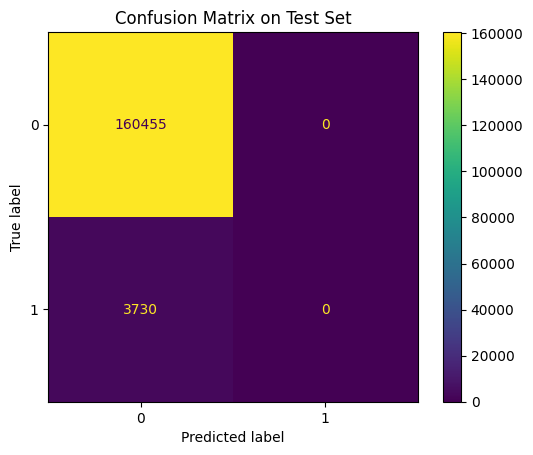

ZeroR Baseline Metrics:   Accuracy: 0.9773   F1 Score: 0.0000   Precision: 0.0000   Recall: 0.0000   AUC: 0.5000   AUC-PR: 0.0227 



In [8]:
model = SGDClassifier(loss='log_loss', max_iter=1000, learning_rate='optimal', warm_start=True)
_ = trainAndEvaluate(model, X_train, X_val, X_test, y_train, y_val, y_test, meter_val, meter_test, epochs=5, batch_size=1024, show=True)

### We have the problem of the heavily imbalanced dataset which we will try to solve by:
1) Using a subset of the dataset with an equal distribution for both target classes
2) Over-sampling the dataset by generating samples from the minor class

In [15]:
# Create a balanced sample from the dataset
class_0 = df[df['anomaly'] == 0]
class_1 = df[df['anomaly'] == 1]

# Sample equal number from each class (based on minority class size)
min_len = min(len(class_0), len(class_1))
df_balanced = pd.concat([
    class_0.sample(min_len, random_state=42),
    class_1.sample(min_len, random_state=42)
], ignore_index=True).sample(frac=1, random_state=42)  # Shuffle

print(df_balanced['anomaly'].value_counts())

anomaly
1    37296
0    37296
Name: count, dtype: int64


In [16]:
# Separate features and target
y = df_balanced['anomaly'].values
X = df_balanced.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df_balanced['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Val/Test split with stratification
X_train_val, X_test, y_train_val, y_test, meter_train_val, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val, meter_train, meter_val = train_test_split(
    X_train_val, y_train_val, meter_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_val[y_val == 1]), len(y_val[y_val == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

30209 30209
3357 3357
3730 3730
(60418, 21) (60418,)
(6714, 21) (6714,)
(7460, 21) (7460,)


In [19]:
results = {}
lrs = [0.01, 0.001, 0.0001]
epochs_list = [5, 30, 100]
for epochs in epochs_list:
    for lr in lrs:
        print(f"Model with lr= {lr} and num_epochs= {epochs}\n")
        model = SGDClassifier(loss='log_loss', max_iter=1000, learning_rate='adaptive', eta0=lr, warm_start=True)
        metrics = trainAndEvaluate(model, X_train, X_val, X_test, y_train, y_val, y_test, meter_val, meter_test, epochs=epochs, batch_size=1024)
        preds = model.predict(X_train)
        propa = model.predict_proba(X_train)
        acc = accuracy_score(y_train, preds)
        f1 = f1_score(y_train, preds, zero_division=0)
        auc = roc_auc_score(y_train, propa[:, 1])
        precision = precision_score(y_train, preds, zero_division=0)
        recall = recall_score(y_train, preds, zero_division=0)
        auprc = average_precision_score(y_train, propa[:, 1])
        print(f"Acc: {acc:<10.2f} F1: {f1:<10.2f} AUC: {auc:<10.2f} Precision: {precision:<10.2f} Recall: {recall:<10.2f} AUPRC: {auprc:<10.2f}")
        results[(lr, epochs)] = metrics

Model with lr= 0.01 and num_epochs= 5



Training: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


Acc: 0.55       F1: 0.61       AUC: 0.59       Precision: 0.54       Recall: 0.68       AUPRC: 0.60      
Model with lr= 0.001 and num_epochs= 5



Training: 100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


Acc: 0.57       F1: 0.60       AUC: 0.60       Precision: 0.56       Recall: 0.65       AUPRC: 0.60      
Model with lr= 0.0001 and num_epochs= 5



Training: 100%|██████████| 5/5 [00:00<00:00, 14.54it/s]


Acc: 0.57       F1: 0.60       AUC: 0.61       Precision: 0.56       Recall: 0.64       AUPRC: 0.60      
Model with lr= 0.01 and num_epochs= 30



Training: 100%|██████████| 30/30 [00:01<00:00, 15.22it/s]


Acc: 0.56       F1: 0.60       AUC: 0.59       Precision: 0.55       Recall: 0.67       AUPRC: 0.59      
Model with lr= 0.001 and num_epochs= 30



Training: 100%|██████████| 30/30 [00:02<00:00, 13.38it/s]


Acc: 0.57       F1: 0.59       AUC: 0.60       Precision: 0.56       Recall: 0.61       AUPRC: 0.59      
Model with lr= 0.0001 and num_epochs= 30



Training: 100%|██████████| 30/30 [00:02<00:00, 14.03it/s]


Acc: 0.57       F1: 0.60       AUC: 0.60       Precision: 0.56       Recall: 0.65       AUPRC: 0.60      
Model with lr= 0.01 and num_epochs= 100



Training: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s]


Acc: 0.56       F1: 0.55       AUC: 0.58       Precision: 0.57       Recall: 0.54       AUPRC: 0.58      
Model with lr= 0.001 and num_epochs= 100



Training: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Acc: 0.58       F1: 0.57       AUC: 0.60       Precision: 0.58       Recall: 0.56       AUPRC: 0.60      
Model with lr= 0.0001 and num_epochs= 100



Training: 100%|██████████| 100/100 [00:06<00:00, 14.73it/s]


Acc: 0.57       F1: 0.60       AUC: 0.60       Precision: 0.57       Recall: 0.64       AUPRC: 0.60      


In [12]:
print(f"{'LR':<10} {'Epoch':<10} {'Accuracy':<10} {'F1':<10} {'AUC':<10} {'Precision':<10} {'Recall':<10} {'AUC-PR':<10}")
print("-" * 83)
for (lr, epoch), metrics in results.items():
    print(f"{lr:<10} {epoch:<10} {metrics[0]:<10.2f} {metrics[1]:<10.2f} {metrics[2]:<10.2f} {metrics[3]:<10.2f} {metrics[4]:<10.2f} {metrics[5]:<10.2f}")

LR         Epoch      Accuracy   F1         AUC        Precision  Recall     AUC-PR    
-----------------------------------------------------------------------------------
0.01       5          0.56       0.59       0.58       0.55       0.63       0.59      
0.001      5          0.57       0.60       0.61       0.56       0.65       0.61      
0.0001     5          0.57       0.60       0.61       0.56       0.64       0.61      
0.01       30         0.56       0.55       0.58       0.56       0.54       0.57      
0.001      30         0.57       0.59       0.60       0.56       0.61       0.60      
0.0001     30         0.57       0.60       0.61       0.56       0.64       0.61      
0.01       100        0.56       0.54       0.58       0.56       0.53       0.56      
0.001      100        0.58       0.58       0.61       0.58       0.58       0.61      
0.0001     100        0.57       0.60       0.61       0.56       0.63       0.61      


In [13]:
# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Save meter_reading column separately
meter_reading = df['meter_reading'].values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test, meter_train_val, meter_test = train_test_split(
    X, y, meter_reading, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val, meter_train, meter_val = train_test_split(
    X_train_val, y_train_val, meter_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_val[y_val == 1]), len(y_val[y_val == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

1299681 1299681
3357 144409
3730 160455
(2599362, 21) (2599362,)
(147766, 21) (147766,)
(164185, 21) (164185,)


In [22]:
results = {}
lrs = [0.01, 0.001, 0.0001]
epochs_list = [5, 30, 100]
for epochs in epochs_list:
    for lr in lrs:
        print(f"Model with lr= {lr} and num_epochs= {epochs}\n")
        model = SGDClassifier(loss='log_loss', max_iter=1000, learning_rate='adaptive', eta0=lr, warm_start=True)
        metrics = trainAndEvaluate(model, X_train, X_val, X_test, y_train, y_val, y_test, meter_val, meter_test, epochs=epochs, batch_size=1024)
        results[(lr, epochs)] = metrics

Model with lr= 0.01 and num_epochs= 5



Training: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


Model with lr= 0.001 and num_epochs= 5



Training: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


Model with lr= 0.0001 and num_epochs= 5



Training: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Model with lr= 0.01 and num_epochs= 30



Training: 100%|██████████| 30/30 [01:32<00:00,  3.07s/it]


Model with lr= 0.001 and num_epochs= 30



Training: 100%|██████████| 30/30 [01:36<00:00,  3.20s/it]


Model with lr= 0.0001 and num_epochs= 30



Training: 100%|██████████| 30/30 [01:35<00:00,  3.20s/it]


Model with lr= 0.01 and num_epochs= 100



Training: 100%|██████████| 100/100 [05:40<00:00,  3.40s/it]


Model with lr= 0.001 and num_epochs= 100



Training: 100%|██████████| 100/100 [05:36<00:00,  3.36s/it]


Model with lr= 0.0001 and num_epochs= 100



Training: 100%|██████████| 100/100 [05:13<00:00,  3.13s/it]


In [23]:
print(f"{'LR':<10} {'Epoch':<10} {'Accuracy':<10} {'F1':<10} {'AUC':<10} {'Precision':<10} {'Recall':<10} {'AUC-PR':<10}")
print("-" * 60)
for (lr, epoch), metrics in results.items():
    print(f"{lr:<10} {epoch:<10} {metrics[0]:<10.2f} {metrics[1]:<10.2f} {metrics[2]:<10.2f} {metrics[3]:<10.2f} {metrics[4]:<10.2f} {metrics[5]:<10.2f}")

LR         Epoch      Accuracy   F1         AUC        Precision  Recall     AUC-PR    
------------------------------------------------------------
0.01       5          0.63       0.06       0.60       0.03       0.54       0.03      
0.001      5          0.62       0.06       0.62       0.03       0.58       0.03      
0.0001     5          0.62       0.06       0.62       0.03       0.58       0.03      
0.01       30         0.62       0.06       0.59       0.03       0.54       0.03      
0.001      30         0.65       0.06       0.62       0.03       0.55       0.03      
0.0001     30         0.62       0.06       0.62       0.03       0.57       0.03      
0.01       100        0.67       0.06       0.59       0.03       0.48       0.03      
0.001      100        0.64       0.06       0.61       0.03       0.55       0.03      
0.0001     100        0.62       0.06       0.62       0.03       0.58       0.03      


### We can see that Logistic Regression performs badly even after these improvements.  
### This means our dataset can't be linearly seperated and non-linear models should be used.